In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy

### 2 Individual Implementation of Blocks

In [3]:
# 2.1
def Divide(seq):
    length = len(seq)
    if length % 2 != 0:
        raise ValueError("Invalid Input: Sequence length is not even.")

    # Initialize two sequences
    seq1 = []
    seq2 = []

    # Choose even elements of the input sequence
    for i in range(length//2):
        seq1.append(seq[2*i])

    # Choose odd elements fo the input sequence
    for i in range(length//2):
        seq2.append(seq[2*i+1])

    return seq1, seq2

def Combine(seq1, seq2):
    if len(seq1) != len(seq2):
        raise ValueError("Invalid Input: The Sequences don't have the same length")

    seq = []

    for i in range(len(seq1)):
        # Add even elements
        seq.append(seq1[i])
        # Add odd elements
        seq.append(seq2[i])

    return seq

In [20]:
# 2.2
def PulseShaping(seq, zero_pulse, one_pulse):
    if len(zero_pulse) != len(one_pulse):
        raise ValueError("Invalid Pulse Length: Different Pulse Length")

    # Initialize the result
    pulse_len = len(zero_pulse)
    result_wave = np.zeros(len(seq) * pulse_len)

    for i, bit in enumerate(seq):
        if bit == 0:
            result_wave[i * pulse_len : (i + 1) * pulse_len] += zero_pulse
        elif bit == 1:
            result_wave[i * pulse_len : (i + 1) * pulse_len] += one_pulse
        else:
            raise ValueError("Invalid Sequence: Sequence contains bits other than one or zero")

    return result_wave

In [5]:
# 2.3
def AnalogMod(signal1, signal2, fs, fc):
    """
    :param signal1: 1st baseband signal
    :param signal2: 2nd baseband signal
    :param fs: sampling frequency
    :param fc: carrier frequency
    :return:
    """
    # Define time
    time = np.arange(len(signal1))/fs

    # Generate carrier signals
    carrier_cos = np.cos(2 * np.pi * fc * time)
    carrier_sin = np.sin(2 * np.pi * fc * time)

    # Modulate signal
    mod_signal = signal1 * carrier_cos + signal2 * carrier_sin

    return mod_signal

In [25]:
# 2.4
def Channel(signal , fs, f_center, bandwidth):
    f_ny = fs/ 2.0
    f_cut_low = f_center - bandwidth / 2.0
    f_cut_high = f_center + bandwidth / 2.0

    # Determine filter parameters
    b, a = scipy.signal.butter(4, [f_cut_low/f_ny, f_cut_high/f_ny], btype='band')

    # Filter the signal
    filtered_signal = scipy.signal.lfilter(b, a, signal)

    return filtered_signal

In [7]:
# 2.5
def AnalogDemod(signal, fs, bandwidth, fc):
    # Define time
    time = np.arange(len(signal))/fs

    # Generate carrier signals
    carrier_cos = np.cos(2 * np.pi * fc * time)
    carrier_sin = np.sin(2 * np.pi * fc * time)

    # Demodulate signal
    dem_signal1 = signal * carrier_cos
    dem_signal2 = signal * carrier_sin

    # Define LPF
    f_ny = fs/2.0
    f_cut = bandwidth / 2.0
    order = 4
    b, a = scipy.signal.butter(order, f_cut/f_ny, btype='low')

    # Filter signal
    dem_signal1 = scipy.signal.lfilter(b, a, dem_signal1)
    dem_signal2 = scipy.signal.lfilter(b, a, dem_signal2)

    return dem_signal1, dem_signal2

In [8]:
# 2.6
def MatchedFilter(dem_signal, zero_pulse, one_pulse):
    # Define zero matched filter output
    zero_match_filter_out = scipy.signal.correlate(dem_signal, zero_pulse, mode='same')

    # Define one matched filter output
    one_match_filter_out = scipy.signal.correlate(dem_signal, one_pulse, mode='same')

    # Estimate bit values
    result_seq = np.where(one_match_filter_out > zero_match_filter_out,1, 0)

    return one_match_filter_out, zero_match_filter_out, result_seq

In [9]:
def sample_and_quantize(pulse, estimates_sequence):
    l_pulse = len(pulse)
    l = int(len(estimates_sequence)/l_pulse)
    estimated_bits = np.zeros(l)
    step = int(l_pulse/2)
    for i in range(l):
        if estimates_sequence[step + i*l_pulse] > 0:
            estimated_bits[i] = 1
    return estimated_bits

### 3 Transmission of Random Sequence of Zeros and Ones

In [10]:
# Determine parameters
fs = 1e6 # Sampling frequency
pulse_len = 1e-2 # Pulse length
fc = 1e4 # Carrier frequency
f_center = 1e4 # Channel central frequency
bandwidth = 1e3 # Cahnnel bandwidth

#### 3.1.1

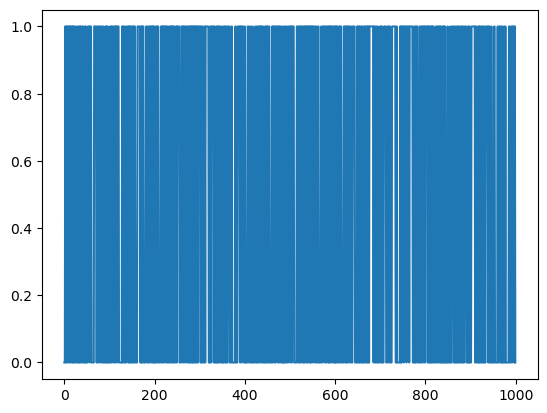

In [11]:
length = 1000
seq = np.random.randint(2, size=length)
plt.plot(seq)

The bandwidth is determined by finding the index where the normalized spectrum drops below a certain threshold. In this case, the threshold is set to 0.05.

In [12]:
# finding message signals bandwidth
def calculate_bandwidth(signal, fs):
    spec = np.fft.fft(signal)
    abs_spec = np.abs(spec)
    half_length = len(signal) // 2
    normalized_spectrum = abs_spec[:half_length] / np.max(abs_spec)
    frequency_axis = np.fft.fftfreq(len(signal), 1 / fs)[:half_length]

    # Search for the index where the spectrum is below the threshold
    threshold = 0.05  # Adjust this threshold as per your requirements
    bandwidth_index = np.where(normalized_spectrum < threshold)[0][0]

    bandwidth = 2 * frequency_axis[bandwidth_index]
    return bandwidth

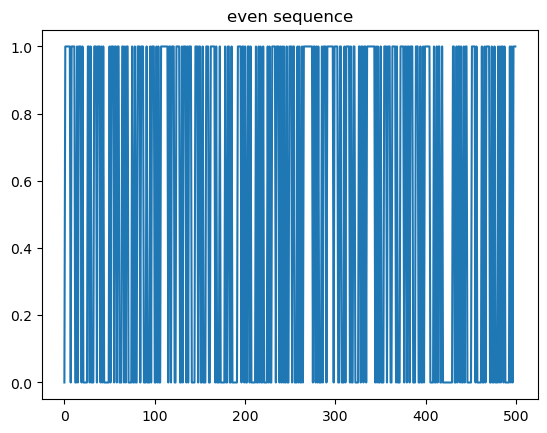

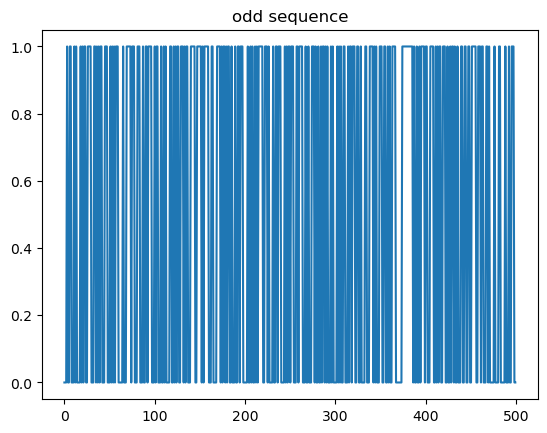

In [13]:
# Transmitter
# Divide Block
s_1 , s_2 = Divide(seq)
plt.plot(s_1)
plt.title("even sequence")
plt.show()
plt.plot(s_2)
plt.title("odd sequence")
plt.show()

In [14]:
bandwidth_1 = calculate_bandwidth(s_1, fs)
print("Bandwidth_1:", bandwidth_1)
bandwidth_2 = calculate_bandwidth(s_2, fs)
print("Bandwidth_2:", bandwidth_2)
signal_bandwidth = max(bandwidth_1, bandwidth_2)

Bandwidth_1: 4000.0
Bandwidth_2: 4000.0


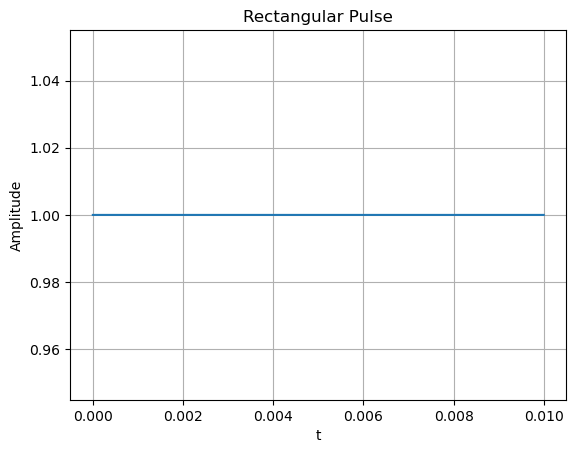

In [15]:
# Pulse shaping block
def rectangular_pulse_gen(duration, amplitude, sampling_frequency):
    num_samples = int(duration * sampling_frequency)
    pulse = np.ones(num_samples) * amplitude
    return pulse

pulse = rectangular_pulse_gen(pulse_len, 1, fs)

# Plot the pulse
time = np.arange(0, pulse_len, 1 / fs)
plt.plot(time, pulse)
plt.xlabel('t')
plt.ylabel('Amplitude')
plt.title('Rectangular Pulse')
plt.grid(True)
plt.show()

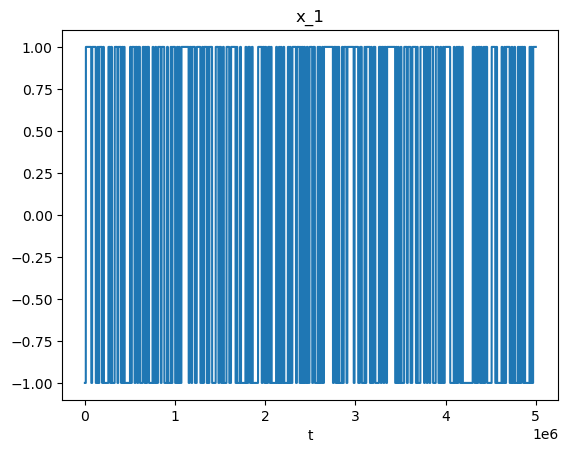

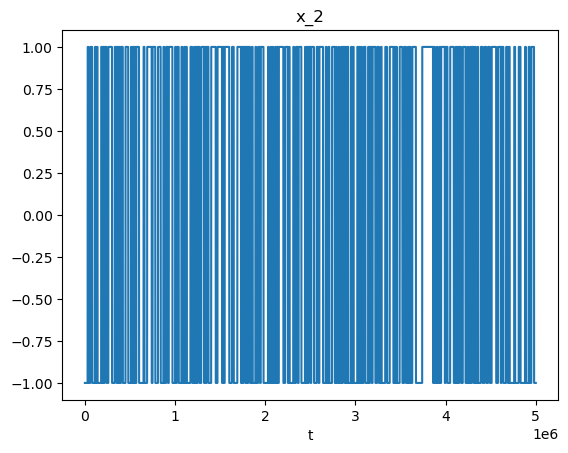

In [21]:
x_1 = PulseShaping(s_1, -1*pulse, pulse)
x_2 = PulseShaping(s_2, -1*pulse, pulse)
plt.plot(x_1)
plt.title("x_1")
plt.xlabel("t")
plt.show()
plt.plot(x_2)
plt.title("x_2")
plt.xlabel("t")
plt.show()

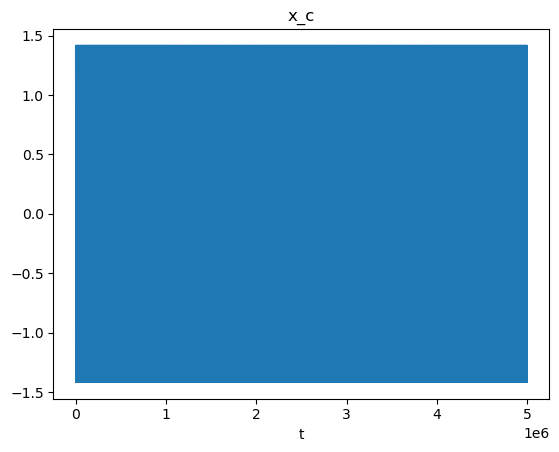

In [22]:
# Modulation Block
x_c = AnalogMod(x_1, x_2, fs, fc)
plt.plot(x_c)
plt.title("x_c")
plt.xlabel("t")
plt.show()

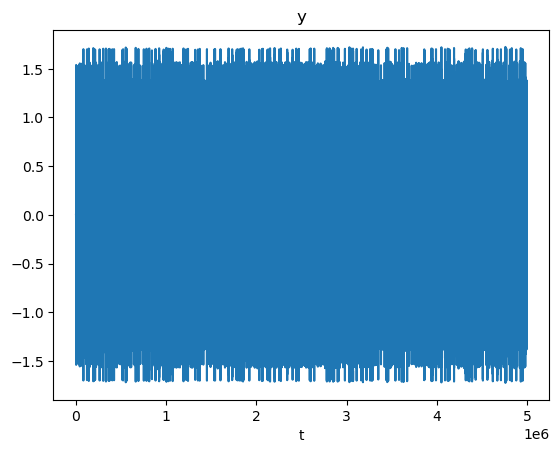

In [26]:
# Receiver -  Channel Block
y = Channel(x_c, fs, f_center,  bandwidth)
plt.plot(y)
plt.title("y")
plt.xlabel("t")
plt.show()

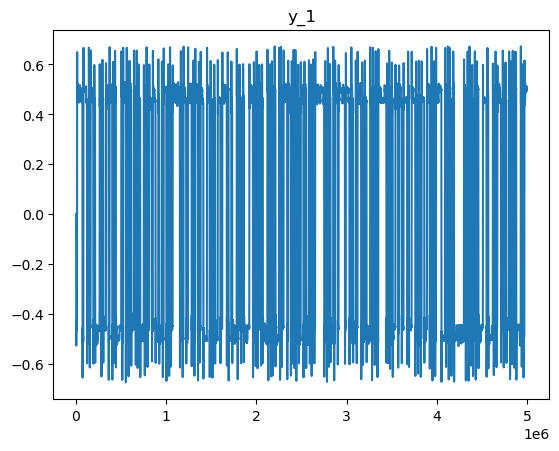

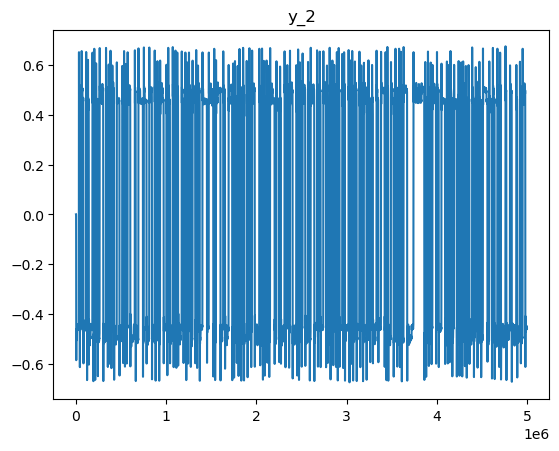

In [28]:
# Demodulation Block
y_1, y_2 = AnalogDemod(y, fs, bandwidth, fc)
# PLot y1
plt.plot(y_1)
plt.title("y_1")

# Plot y2
plt.show()
plt.plot(y_2)
plt.title("y_2")

plt.show()

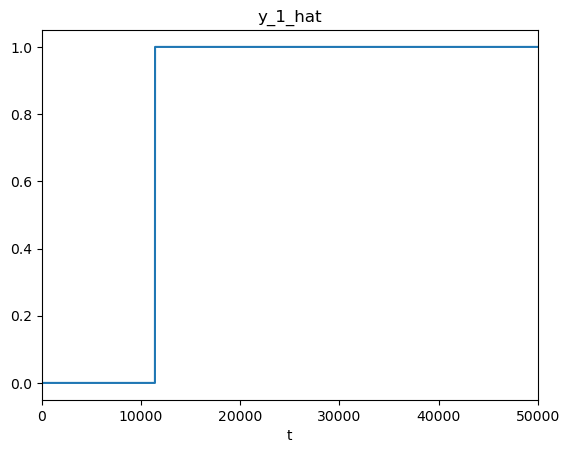

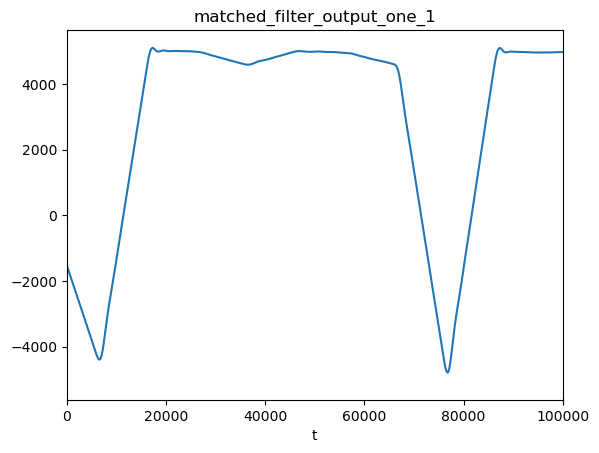

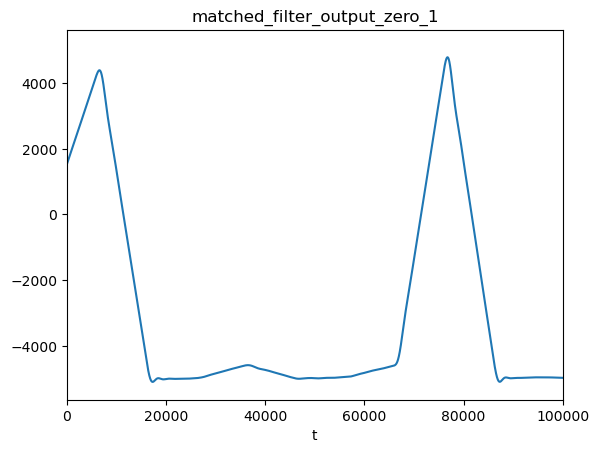

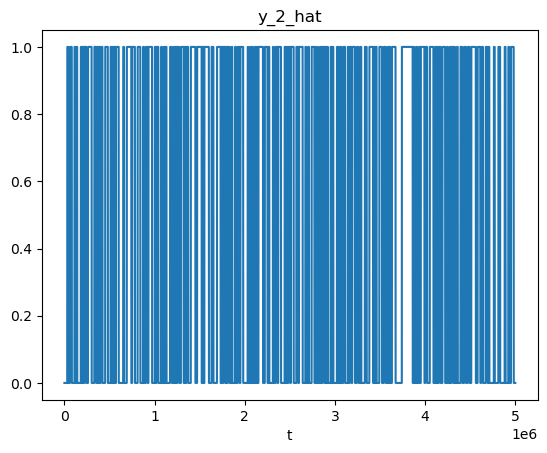

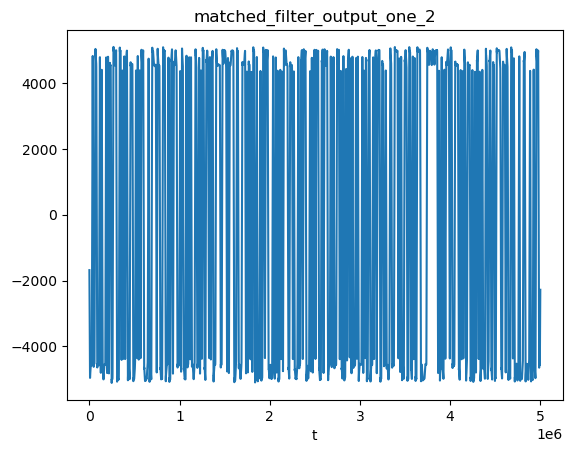

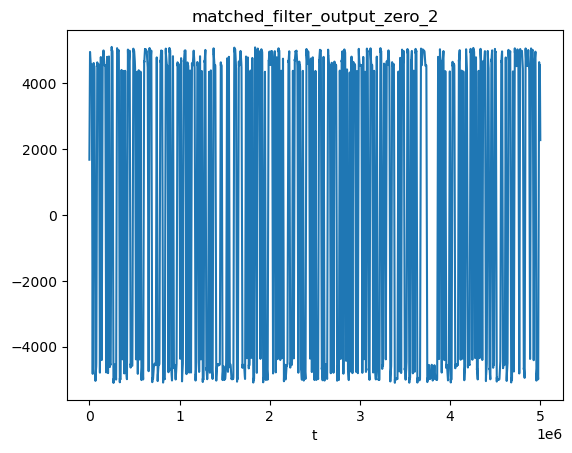

In [31]:
# Matched Filter and Threshold
matched_filter_output_one_1, matched_filter_output_zero_1, y_1_prime = MatchedFilter(y_1, -1*pulse, pulse)
matched_filter_output_one_2, matched_filter_output_zero_2, y_2_prime = MatchedFilter(y_2, -1*pulse, pulse)
plt.plot(y_1_prime)
plt.title("y_1_hat")
plt.xlim(0, 5e4)
plt.xlabel("t")
plt.show()
plt.plot(matched_filter_output_one_1)
plt.title("matched_filter_output_one_1")
plt.xlim(0, 1e5)
plt.xlabel("t")
plt.show()
plt.plot(matched_filter_output_zero_1)
plt.title("matched_filter_output_zero_1")
plt.xlim(0, 1e5)
plt.xlabel("t")
plt.show()

plt.plot(y_2_prime)
plt.title("y_2_hat")
plt.xlabel("t")
plt.show()
plt.plot(matched_filter_output_one_2)
plt.title("matched_filter_output_one_2")
plt.xlabel("t")
plt.show()
plt.plot(matched_filter_output_zero_2)
plt.title("matched_filter_output_zero_2")
plt.xlabel("t")
plt.show()

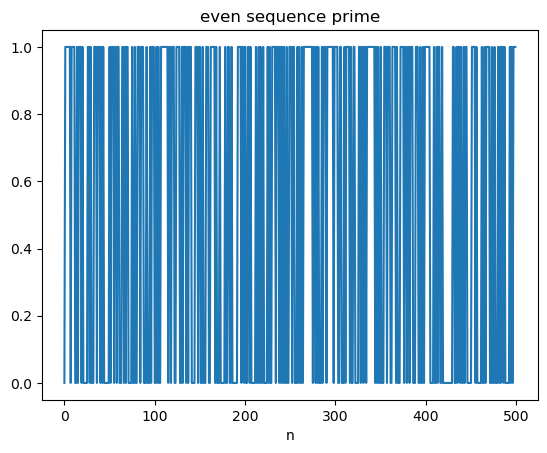

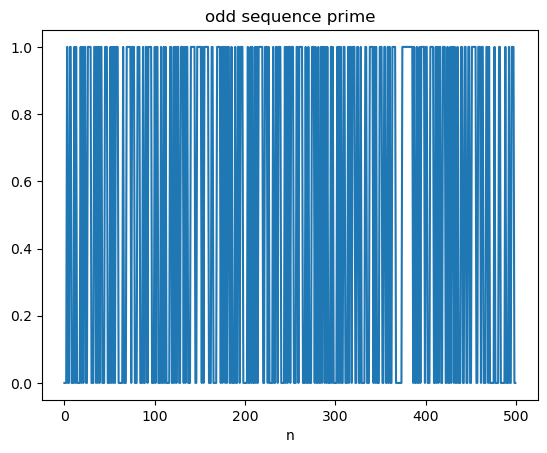

In [35]:
estimated_bit_seq_1 = sample_and_quantize(pulse, y_1_prime)
estimated_bit_seq_2 = sample_and_quantize(pulse, y_2_prime)
plt.plot(estimated_bit_seq_1)
plt.title("even sequence prime")
plt.xlabel("n")
plt.show()

plt.plot(estimated_bit_seq_2)
plt.title("odd sequence prime")
plt.xlabel("n")
plt.show()

In [39]:
seq_prime = Combine(estimated_bit_seq_1, estimated_bit_seq_2)
print("bit error rate:" )
print(np.sum(seq_prime != seq)/len(seq))

bit error rate:
0.0


In [43]:
def sample_and_quantize(pulse, estimates_sequence):
    l_pulse = len(pulse)
    l = int(len(estimates_sequence)/l_pulse)
    estimated_bits = np.zeros(l)
    step = int(l_pulse/2)
    for i in range(l):
        if estimates_sequence[step + i*l_pulse] > 0:
            estimated_bits[i] = 1
    return estimated_bits

Text(0, 0.5, 'error')

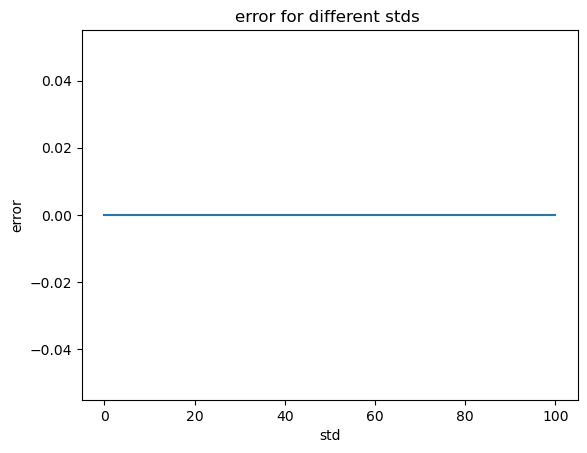

In [44]:
#### 3.1.2

mean = 0
num_samples = len(y)
stds = np.linspace(0, 100, 20)
errors = []
for std in stds:
    white_noise= np.random.normal(mean, std, size=num_samples)
    y_final = y + white_noise

    y_1, y_2 = AnalogDemod(y_final, fs, signal_bandwidth, fc)
    matched_filter_output_one_1, matched_filter_output_zero_1, y_1_hat = MatchedFilter(y_1, -1*pulse, pulse)
    matched_filter_output_one_2, matched_filter_output_zero_2, y_2_hat = MatchedFilter(y_2, -1*pulse, pulse)
    estimated_bit_1 = sample_and_quantize(pulse, y_1_hat)
    estimated_bit_2 = sample_and_quantize(pulse, y_2_hat)
    b = Combine(estimated_bit_1, estimated_bit_2)
    errors.append(np.sum(seq_prime != seq)/len(seq))
plt.plot(stds, errors)
plt.title("error for different stds ")
plt.xlabel("std")
plt.ylabel("error")

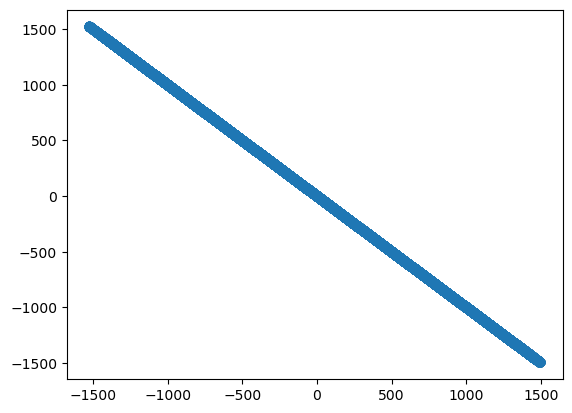

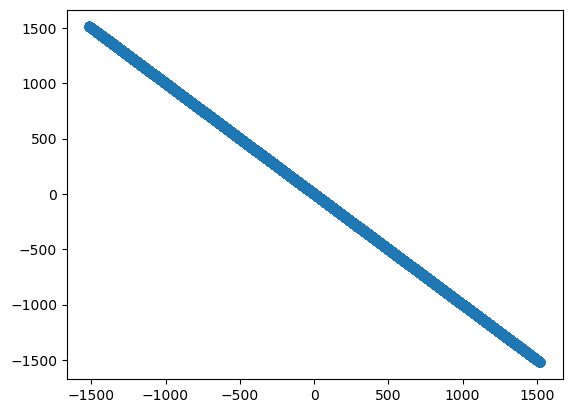

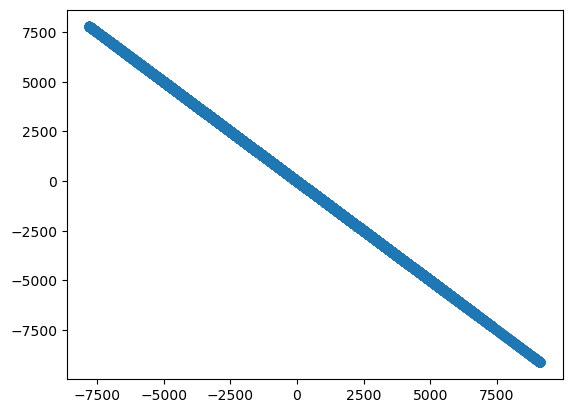

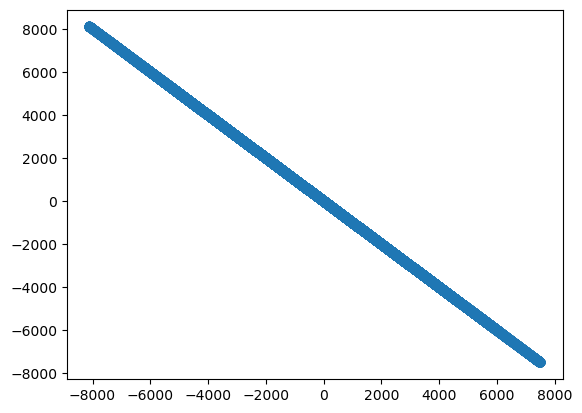

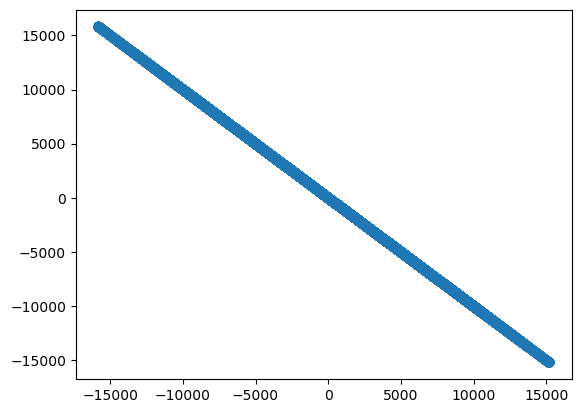

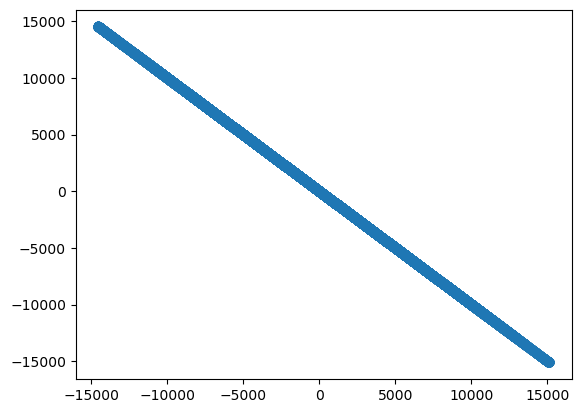

In [58]:
# 3.1.2
mean = 0
stds = [1, 50, 100]
num_samples = len(y)
for std in stds:
    white_noise= np.random.normal(mean, std, size=num_samples)
    y_f = y + white_noise

    y_1, y_2 = AnalogDemod(y_f, fs, bandwidth, fc)
    matched_filter_output_one_1, matched_filter_output_zero_1, y_1_hat = MatchedFilter(y_1, -1*pulse, pulse)
    matched_filter_output_one_2, matched_filter_output_zero_2, y_2_hat = MatchedFilter(y_2, -1*pulse, pulse)
    estimated_bit_1 = sample_and_quantize(pulse, y_1_hat)
    estimated_bit_2 = sample_and_quantize(pulse, y_2_hat)
    plt.scatter(matched_filter_output_zero_1, matched_filter_output_one_1)
    plt.show()
    plt.scatter(matched_filter_output_zero_2, matched_filter_output_one_2)
    plt.show()


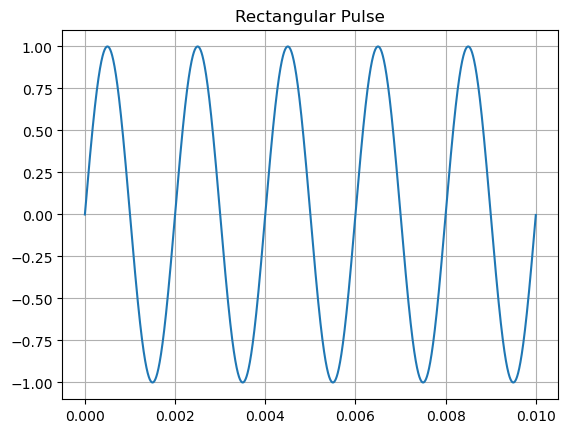

In [45]:
# 3.2.1
# Pulse Shaping Block
def generate_sinusoidal_pulse(frequency, duration, sampling_rate):
    # Generate the time axis
    t = np.linspace(0, duration, int(duration * sampling_rate), endpoint=False)

    # Generate the sinusoidal pulse
    pulse = np.sin(2 * np.pi * frequency * t)

    return pulse
sin_freq = 500
pulse = generate_sinusoidal_pulse(sin_freq, pulse_len, fs)

# Plotting the pulse
time = np.arange(0, pulse_len, 1 / fs)
plt.plot(time, pulse)
plt.title('Rectangular Pulse')
plt.grid(True)
plt.show()

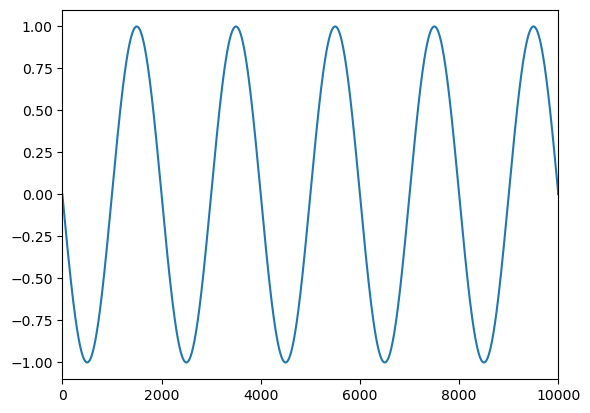

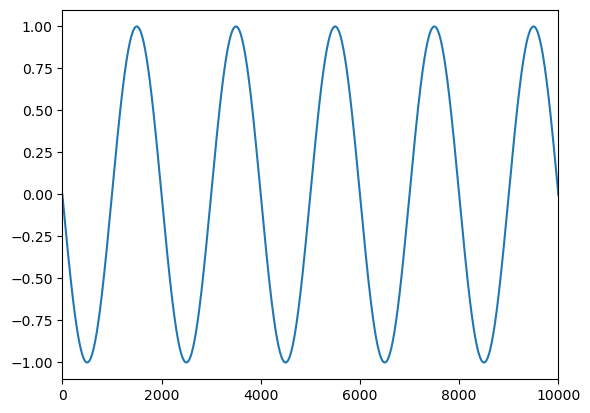

In [48]:
x_1 = PulseShaping(s_1, -1*pulse, pulse)
x_2 = PulseShaping(s_2, -1*pulse, pulse)
plt.plot(x_1)
plt.xlim(0, 1e4)
plt.show()
plt.plot(x_2)
plt.xlim(0, 1e4)
plt.show()

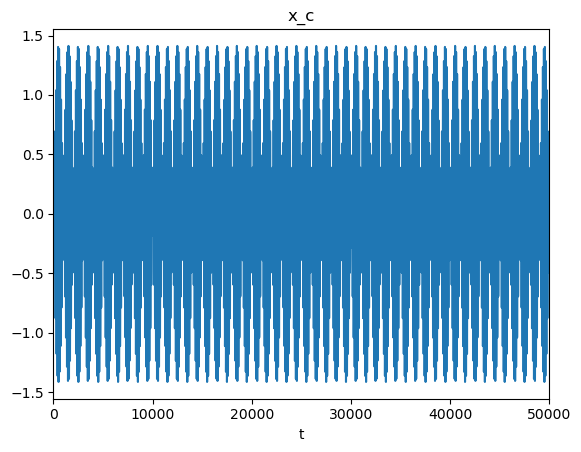

In [49]:
# modulation Block
x_c = AnalogMod(x_1, x_2, fs, fc)
plt.plot(x_c)
plt.title("x_c")
plt.xlim(0, 5e4)
plt.xlabel("t")
plt.show()

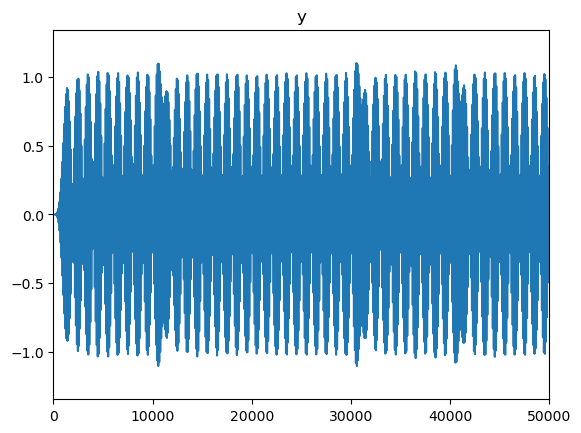

In [51]:
# Receiver
# Channel Block
y = Channel(x_c, fs, f_center, bandwidth)
plt.plot(y)
plt.title("y")
plt.xlim(0, 5e4)
plt.show()

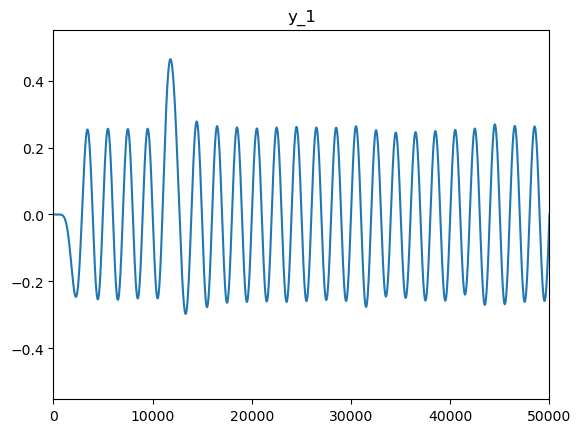

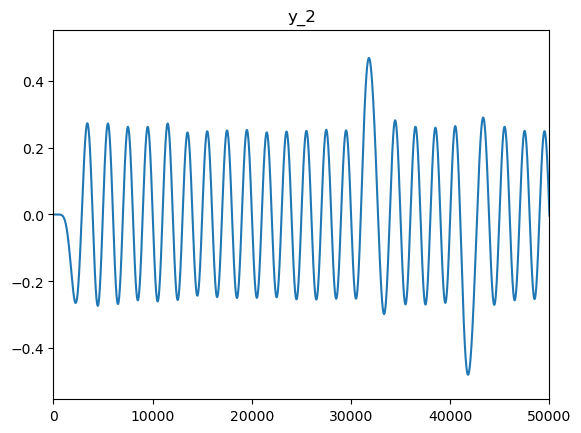

In [53]:
# Demodulation Block
y_1, y_2 = AnalogDemod(y, fs, bandwidth, fc)
plt.plot(y_1)
plt.title("y_1")
plt.xlim(0, 5e4)
plt.show()
plt.plot(y_2)
plt.title("y_2")
plt.xlim(0, 5e4)
plt.show()

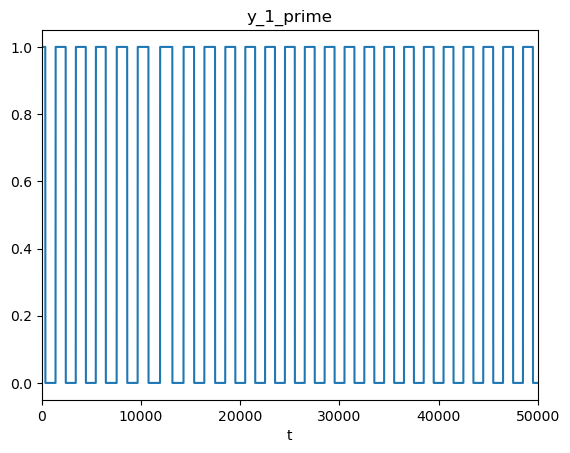

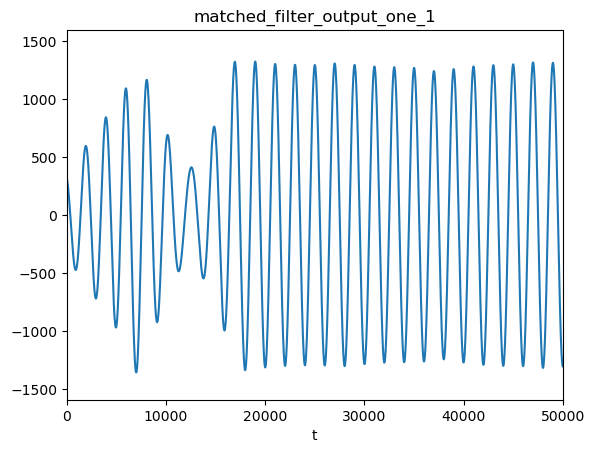

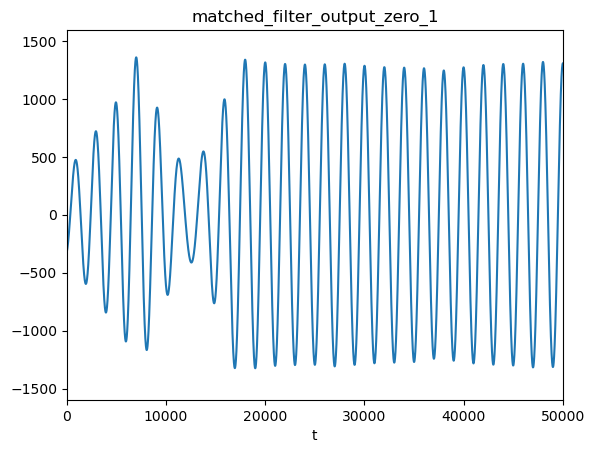

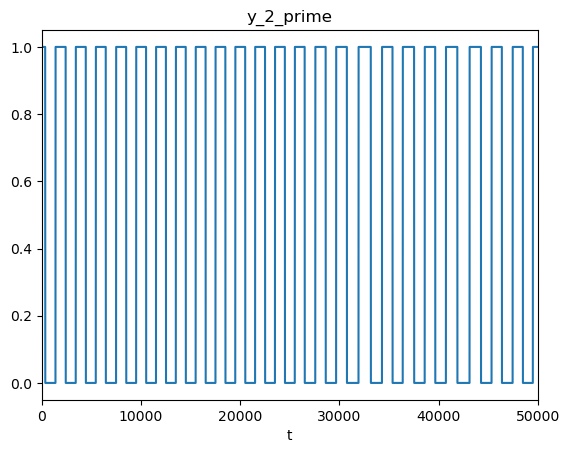

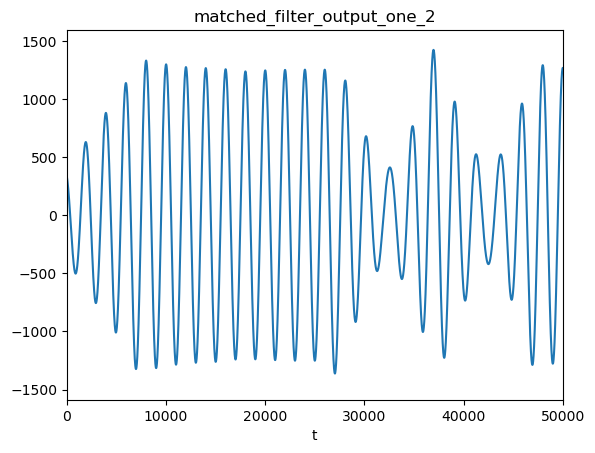

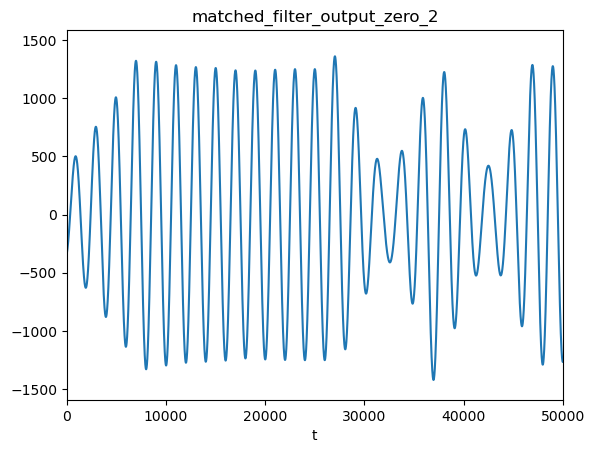

In [54]:
# Matched filter and threshold
matched_filter_output_one_1, matched_filter_output_zero_1,y_1_prime = MatchedFilter(y_1, -1*pulse, pulse)
matched_filter_output_one_2, matched_filter_output_zero_2, y_2_prime = MatchedFilter(y_2, -1*pulse, pulse)
plt.plot(y_1_prime)
plt.title("y_1_prime")
plt.xlim(0, 5e4)
plt.xlabel("t")
plt.show()
plt.plot(matched_filter_output_one_1)
plt.title("matched_filter_output_one_1")
plt.xlim(0, 5e4)
plt.xlabel("t")
plt.show()
plt.plot(matched_filter_output_zero_1)
plt.xlim(0, 5e4)
plt.title("matched_filter_output_zero_1")
plt.xlabel("t")
plt.show()

plt.plot( y_2_prime)
plt.xlim(0, 5e4)
plt.title("y_2_prime")
plt.xlabel("t")
plt.show()
plt.plot(matched_filter_output_one_2)
plt.xlim(0, 5e4)
plt.title("matched_filter_output_one_2")
plt.xlabel("t")
plt.show()
plt.plot(matched_filter_output_zero_2)
plt.xlim(0, 5e4)
plt.title("matched_filter_output_zero_2")
plt.xlabel("t")
plt.show()

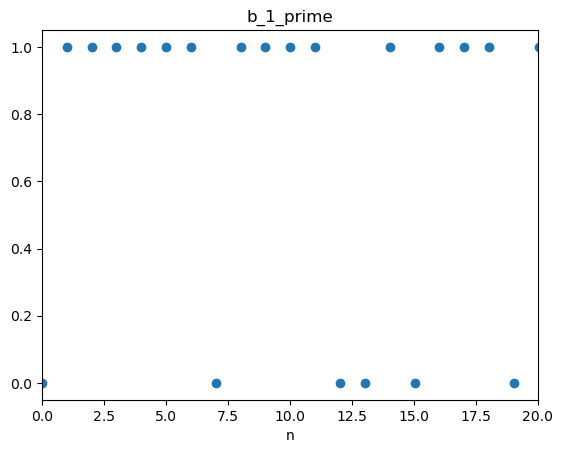

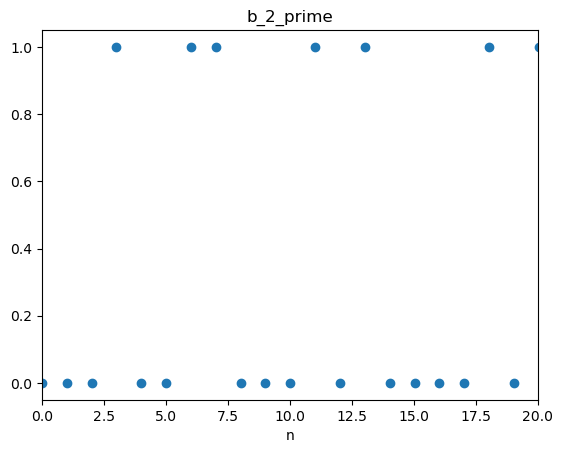

In [56]:
estimated_bit_seq_1 = sample_and_quantize(pulse, y_1_prime)
estimated_bit__seq_2 = sample_and_quantize(pulse,  y_2_prime)
n = np.linspace(0, 500, len(estimated_bit_seq_1))
plt.scatter(n, estimated_bit_1)
plt.title("b_1_prime")
plt.xlim(0, 20)
plt.xlabel("n")
plt.show()

plt.scatter(n, estimated_bit_seq_2)
plt.xlim(0, 20)
plt.title("b_2_prime")
plt.xlabel("n")
plt.show()

In [57]:
seq_prime = Combine(estimated_bit_seq_1, estimated_bit_seq_2)
print("bit error rate:" )
print(np.sum(seq_prime != seq)/len(seq))

bit error rate:
0.0


In [ ]:
# 3.2.2
mean = 0
num_samples = len(y)
stds = np.linspace(0, 100, 20)
errors = []
for std in stds:
    white_noise= np.random.normal(mean, std, size=num_samples)
    y_f = y + white_noise

    y_1, y_2 = AnalogDemod(y_f, fs, bandwidth, fc)
    matched_filter_output_one_1, matched_filter_output_zero_1, y_1_hat = MatchedFilter(y_1, -1*pulse, pulse)
    matched_filter_output_one_2, matched_filter_output_zero_2, y_2_hat = MatchedFilter(y_2, -1*pulse, pulse)
    estimated_bit_1 = sample_and_quantize(pulse, y_1_hat)
    estimated_bit_2 = sample_and_quantize(pulse, y_2_hat)
    b = Combine(estimated_bit_1, estimated_bit_2)
    errors.append(np.sum(b != seq)/len(seq))
plt.plot(stds, errors)
plt.title("error for different deviations ")
plt.xlabel("deviation")
plt.ylabel("error")

In [ ]:
# 3.2.3
mean = 0
stds = [1, 50, 100]
num_samples = len(y)
for std in stds:
    white_noise= np.random.normal(mean, std, size=num_samples)
    y_f = y + white_noise

    y_1, y_2 = AnalogDemod(y_f, fs, bandwidth, fc)
    matched_filter_output_one_1, matched_filter_output_zero_1, y_1_hat = MatchedFilter(y_1, -1*pulse, pulse)
    matched_filter_output_one_2, matched_filter_output_zero_2, y_2_hat = MatchedFilter(y_2, -1*pulse, pulse)
    estimated_bit_1 = sample_and_quantize(pulse, y_1_hat)
    estimated_bit_2 = sample_and_quantize(pulse, y_2_hat)
    plt.scatter(matched_filter_output_zero_1, matched_filter_output_one_1)
    plt.show()
    plt.scatter(matched_filter_output_zero_2, matched_filter_output_one_2)
    plt.show()


In [59]:
# 3.3.2
frequencies = {0: 1500, 1: 1000}  # Frequency mapping for bits

# Generate random bit sequence
num_bits = 1000
bit_sequence = np.random.randint(0, 2, num_bits)
s_1 , s_2 = Divide(seq)

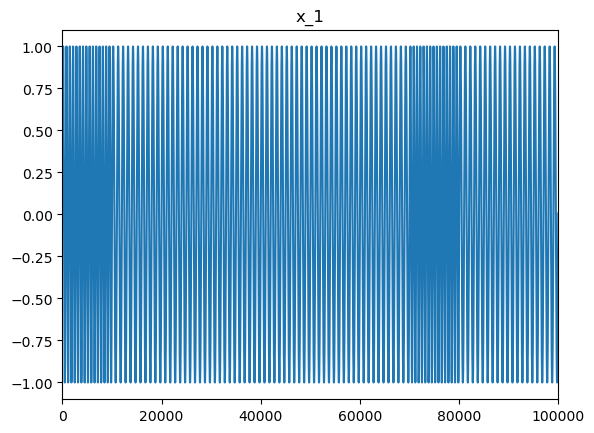

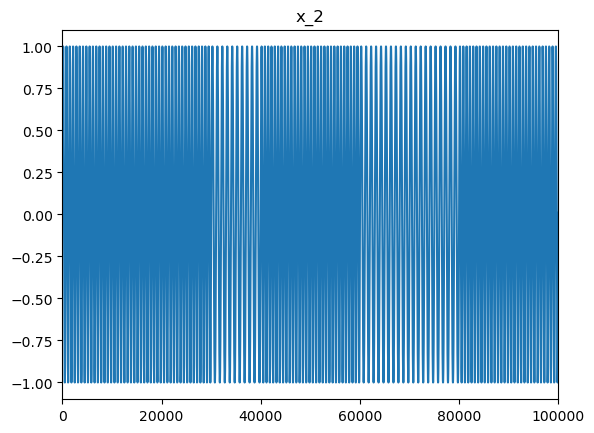

In [60]:
x_1 = PulseShaping(s_1, generate_sinusoidal_pulse(frequencies[0], pulse_len, fs), generate_sinusoidal_pulse(frequencies[1], pulse_len, fs))
x_2 = PulseShaping(s_2, generate_sinusoidal_pulse(frequencies[0], pulse_len,fs), generate_sinusoidal_pulse(frequencies[1], pulse_len, fs))
plt.plot(x_1)
plt.title("x_1")
plt.xlim(0, 1e5)
plt.show()
plt.plot(x_2)
plt.title("x_2")
plt.xlim(0, 1e5)
plt.show()

In [62]:
bandwidth_1 = calculate_bandwidth(s_1, fs)
print("Bandwidth_1:", bandwidth_1)
bandwidth_2 = calculate_bandwidth(s_2, fs)
print("Bandwidth_2:", bandwidth_2)
signal_bandwidth = max(bandwidth_1, bandwidth_2)

Bandwidth_1: 4000.0
Bandwidth_2: 4000.0


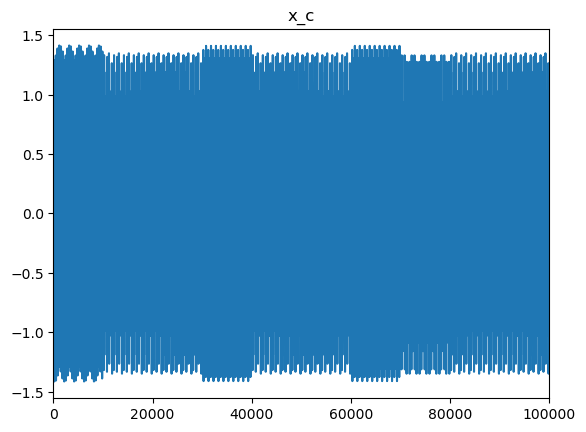

In [65]:
# Modulation Block
x_c = AnalogMod(x_1, x_2, fs, fc)
plt.plot(x_c)
plt.title("x_c")
plt.xlim(0, 1e5)
plt.show()

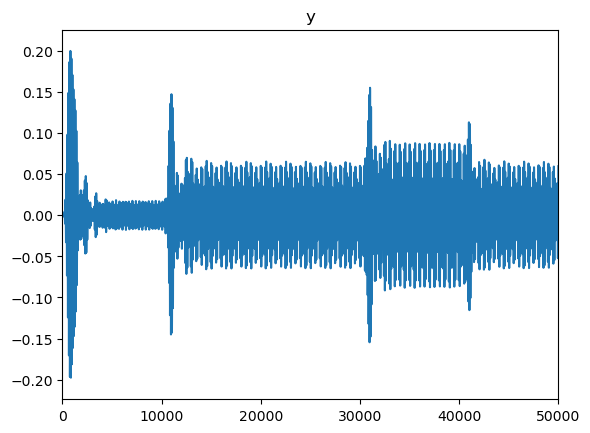

In [66]:
# Receiver
# Channel Block
y = Channel(x_c, fs, fc, bandwidth)
plt.plot(y)
plt.title("y")
plt.xlim(0, 5e4)

plt.show()

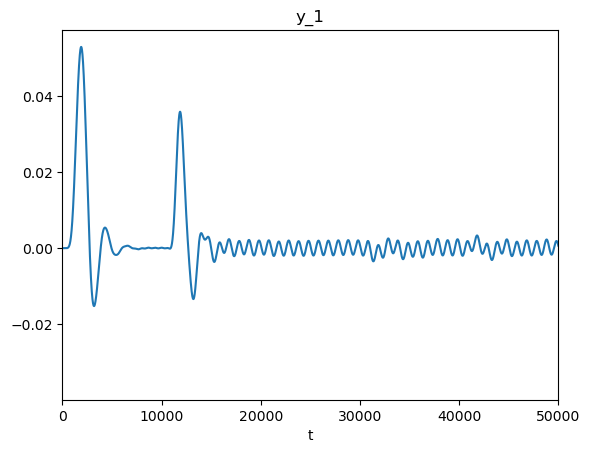

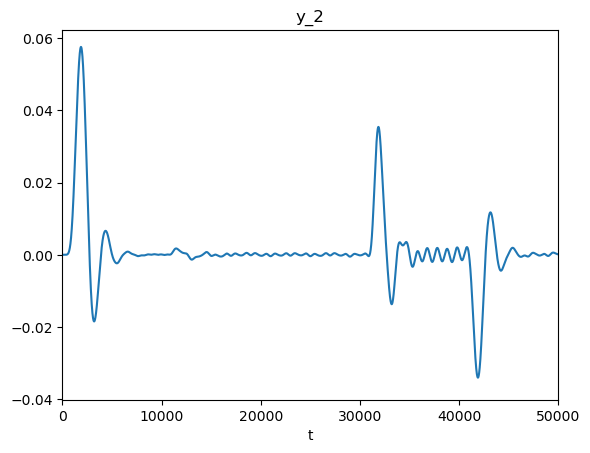

In [67]:
# Demodulation Block
y_1, y_2 = AnalogDemod(y, fs, bandwidth, fc)
plt.plot(y_1)
plt.title("y_1")
plt.xlabel("t")
plt.xlim(0, 5e4)
plt.show()
plt.plot(y_2)
plt.title("y_2")
plt.xlim(0, 5e4)
plt.xlabel("t")
plt.show()

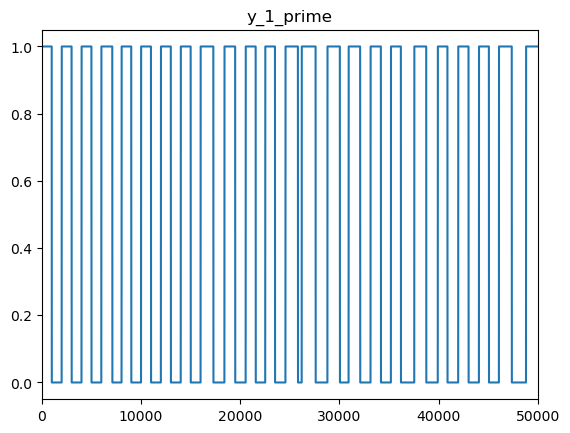

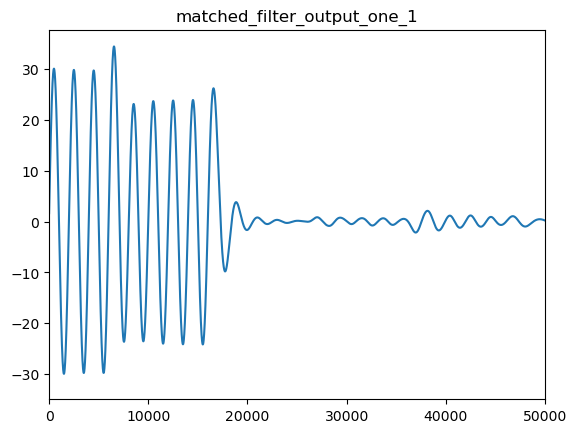

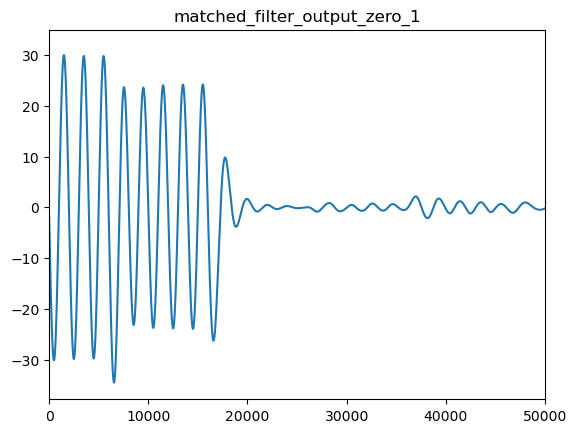

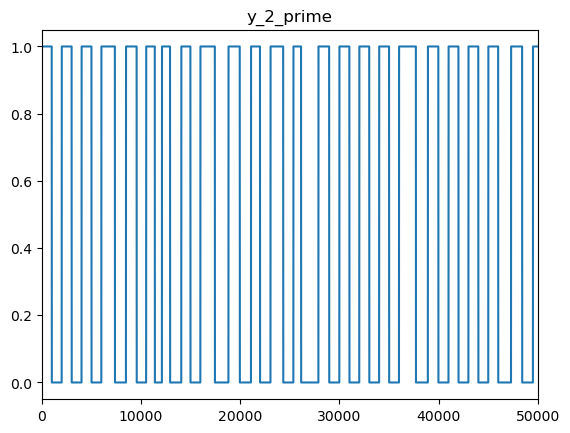

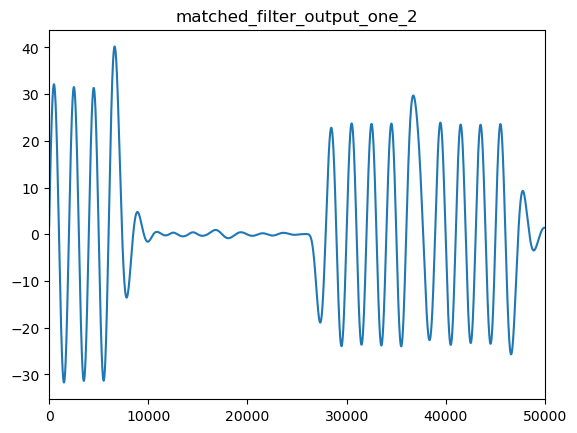

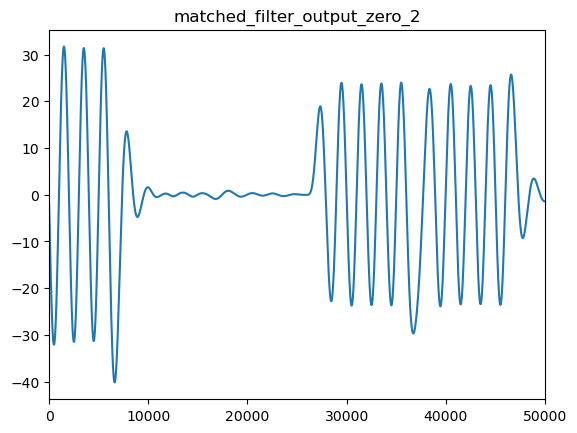

In [69]:
# Matched filter and threshold
matched_filter_output_one_1, matched_filter_output_zero_1, y_1_prime = MatchedFilter(y_1, -1*pulse, pulse)
matched_filter_output_one_2, matched_filter_output_zero_2, y_2_prime = MatchedFilter(y_2, -1*pulse, pulse)
plt.plot(y_1_prime)
plt.title("y_1_prime")
plt.xlim(0, 5e4)
plt.show()
plt.plot(matched_filter_output_one_1)
plt.title("matched_filter_output_one_1")
plt.xlim(0, 5e4)
plt.show()
plt.plot(matched_filter_output_zero_1)
plt.xlim(0, 5e4)
plt.title("matched_filter_output_zero_1")
plt.show()
plt.plot(y_2_prime)
plt.xlim(0, 5e4)
plt.title("y_2_prime")
plt.show()
plt.plot(matched_filter_output_one_2)
plt.xlim(0, 5e4)
plt.title("matched_filter_output_one_2")
plt.show()
plt.plot(matched_filter_output_zero_2)
plt.xlim(0, 5e4)
plt.title("matched_filter_output_zero_2")
plt.show()

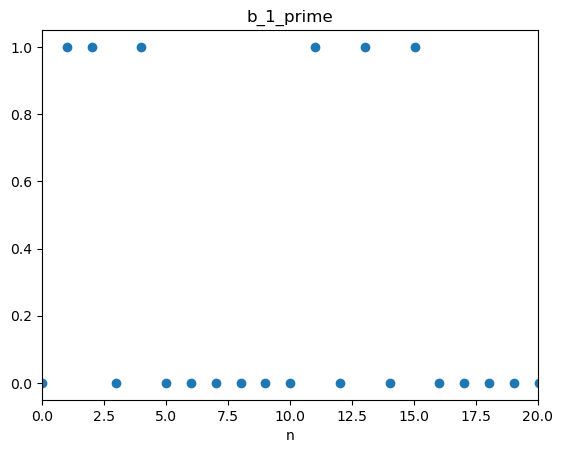

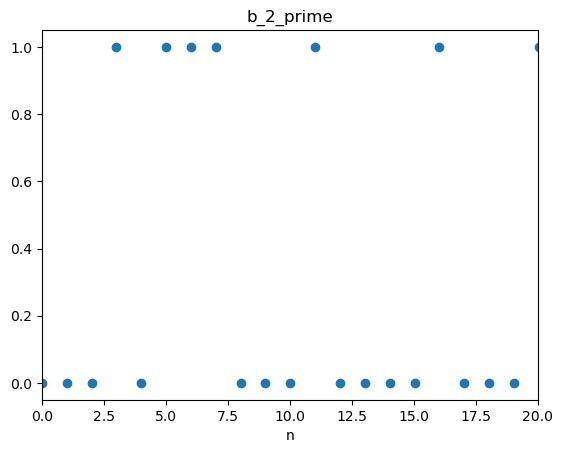

In [74]:
estimated_bit_seq_1 = sample_and_quantize(pulse, y_1_prime)
estimated_bit_seq_2 = sample_and_quantize(pulse, y_2_prime)
n = np.linspace(0, 500, len(estimated_bit_1))
plt.scatter(n, estimated_bit_seq_1)
plt.title("b_1_prime")
plt.xlim(0, 20)
plt.xlabel("n")
plt.show()

plt.scatter(n, estimated_bit_seq_2)
plt.xlim(0, 20)
plt.title("b_2_prime")
plt.xlabel("n")
plt.show()

In [75]:
b = Combine(estimated_bit_seq_1, estimated_bit_seq_2)
print("bit error rate:" )
print(np.sum(b != seq)/len(seq))

bit error rate:
0.001


In [ ]:
# 3.3
mean = 0
num_samples = len(y)
stds = np.linspace(0, 100, 20)
errors = []
for std in stds:
    white_noise= np.random.normal(mean, std, size=num_samples)
    y_f = y + white_noise
    y_1, y_2 = AnalogDemod(y_f, fs, bandwidth, fc)
    matched_filter_output_one_1, matched_filter_output_zero_1, y_1_hat = MatchedFilter(y_1, -1*pulse, pulse)
    matched_filter_output_one_2, matched_filter_output_zero_2, y_2_hat = MatchedFilter(y_2, -1*pulse, pulse)
    estimated_bit_1 = sample_and_quantize(pulse, y_1_hat)
    estimated_bit_2 = sample_and_quantize(pulse, y_2_hat)
    b = Combine(estimated_bit_1, estimated_bit_2)
    errors.append(np.sum(b != seq)/len(seq))
plt.plot(stds, errors)
plt.title("error for different stds ")
plt.xlabel("std")
plt.ylabel("error")

In [ ]:
# 3.4
mean = 0
stds = [1, 50, 100]
num_samples = len(y)
for std in stds:
    white_noise= np.random.normal(mean, std, size=num_samples)
    y_final = y + white_noise
    #plt.plot(y_final)
    #plt.show()
    y_1, y_2 = AnalogDemod(y_final, sampling_frequency, signal_bandwidth, carrier_frequency)
    matched_filter_output_one_1, matched_filter_output_zero_1, y_1_hat = MatchedFilter(y_1, -1*pulse, pulse)
    matched_filter_output_one_2, matched_filter_output_zero_2, y_2_hat = MatchedFilter(y_2, -1*pulse, pulse)
    estimated_bit_1 = sample_and_quantize(pulse, y_1_hat)
    estimated_bit_2 = sample_and_quantize(pulse, y_2_hat)
    plt.scatter(matched_filter_output_zero_1, matched_filter_output_one_1)
    plt.show()
    plt.scatter(matched_filter_output_zero_2, matched_filter_output_one_2)
    plt.show()

## 3.4



PSK (Phase Shift Keying):

Definition: PSK is a digital modulation technique where the phase of the carrier signal is varied in relation to the digital input signal.
Key Point: In PSK, different phase shifts represent different binary states(0 and 1).
Advantages: PSK is efficient in terms of bandwidth utilization and is commonly used in high-speed data transmission.
Applications: Widely used in wireless communication systems, satellite communication.

PAM (Pulse Amplitude Modulation):

Definition: PAM is a digital modulation technique in which the amplitude of the pulse carrier is varied in proportion to the analog signal being transmitted.
Key Point: In PAM, different levels of amplitude represent different signal levels.
Advantages: PAM is relatively simple and can be implemented using basic electronics.
Applications: Used in pulse code modulation (PCM) for digital audio transmission, ADSL (Asymmetric Digital Subscriber Line) communication.

FSK (Frequency Shift Keying):

Definition: FSK is a digital modulation technique in which the frequency of the carrier signal is varied in proportion to the digital signal.
Key Point: In FSK, different frequencies represent different binary states.
Advantages: It is relatively simple to implement and can be less affected by noise.
Applications: Used in telecommunications, RFID systems, and wireless networks.



###